In [1]:
# For each iteration of outputs, plot the objective functions for each basins and save to a PDF file

In [24]:
import numpy as np
import os, glob, sys, toml
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from itertools import combinations
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import Normalize
import matplotlib.cm as cm

sys.path.append('/glade/u/home/guoqiang/CTSM_repos/ctsm_optz/MO-ASMO/src')
import NSGA2

# Load data

In [25]:
# basin info
file = '/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv'
ds_info = pd.read_csv(file)

In [28]:
# find basins with zbedrock parameter (wrong sampling)
zbedflag = []
for id in ds_info['hru_id'].values:
    df = pd.read_csv(f'/glade/work/guoqiang/CTSM_CAMELS/data_paramcailb/ParamCalib_basinparam_{id}.csv')
    if 'zbedrock' in df['Parameter'].values:
        zbedflag.append(True)
    else:
        zbedflag.append(False)
zbedflag = np.array(zbedflag)

In [4]:
inpath = '/glade/campaign/cgd/tss/people/guoqiang/CTSMcases_Cheyenne_campaign_out/CAMELS_Calib/Calib_all_HH_MOASMO/'
basinnum = 100
iternum = 9
trialnum = 180 + (iternum-1)*36

# 2: GPR, RF; 

model_metrics = np.nan * np.zeros([basinnum, trialnum, 3]) # metric-1, metric-2, iter 


for i in range(basinnum):

    flag = 0
    for j in range(iternum):
        
        # ctsm model metrics
        filemet = f'{inpath}/level1_{i}_MOASMOcalib/ctsm_outputs/iter{j}_all_metric.csv'

        if not os.path.isfile(filemet):
            break
        
        dfi = pd.read_csv(filemet)
        dfi['iter'] = j

        model_metrics[i, flag:flag+len(dfi), :] = dfi.values

        flag = flag+len(dfi)
        

# Evaluation-1
1. I have results from all iterations
2. I calculate the rank of all simulations for all iterations
3. For each iteration, I calculate the mean rank from its simulations and minimum rank from its simulations
4. I plot the mean rank and minimum rank with iterations

For the minimum rank, if it decreases with iterations, this is means calibration finds better solutions. For mean rank, it is less obvious compared to minimum rank because it shows the average of all simulations within an iteration.

In [11]:
iterranks = np.nan * np.zeros([basinnum, iternum, 2])

for tarbasin in range(0, basinnum):
    met = model_metrics[tarbasin, :, 0:2]
    iters = model_metrics[tarbasin, :, 2]

    if np.any(np.isnan(met)):
        continue
    
    rank, dom = NSGA2.fast_non_dominated_sort(met)

    for i in range(iternum):
        ranki = rank[iters==i]
        iterranks[tarbasin,i,0] = np.mean(ranki)
        iterranks[tarbasin,i,1] = np.min(ranki)

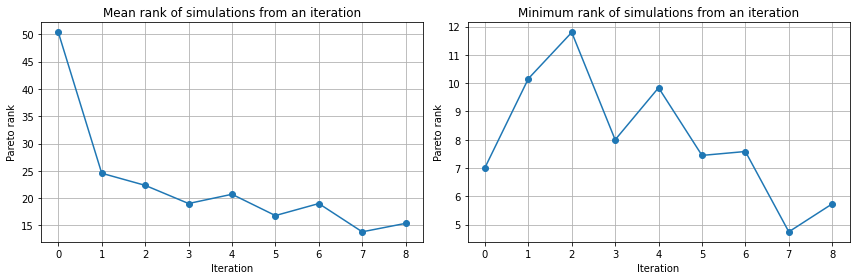

In [31]:
# mean ranks

fig = plt.figure(figsize=[12, 4])

fig.add_subplot(1,2,1)
d1 = np.nanmean(iterranks[:,:,0],axis=0)
plt.plot(d1, '-o')
plt.grid('on')
plt.xlabel('Iteration')
plt.ylabel('Pareto rank')
plt.title('Mean rank of simulations from an iteration')


fig.add_subplot(1,2,2)
d1 = np.nanmean(iterranks[:,:,1],axis=0)
plt.plot(d1, '-o')
plt.grid('on')
plt.xlabel('Iteration')
plt.ylabel('Pareto rank')
plt.title('Minimum rank of simulations from an iteration')

plt.tight_layout()
plt.show()